#### reading material

In [1]:
# https://support.sas.com/resources/papers/proceedings/proceedings/sugi30/203-30.pdf
# https://books.google.co.il/books?id=KFAnkvqD8CgC&pg=PA61&redir_esc=y#v=onepage&q&f=false
# https://www.theanalysisfactor.com/the-fundamental-difference-between-principal-component-analysis-and-factor-analysis/
# https://www.mathworks.com/help/stats/examples/factor-analysis.html
# https://iescoders.com/exploratory-factor-analysis/
# https://nwfsc-timeseries.github.io/atsa-labs/sec-dfa-example1.html
# https://scikit-learn.org/stable/modules/decomposition.html#fa

In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from tqdm.auto import tqdm 

import seaborn as sns

import geopandas as gp
import geoplot
import geoplot.crs as gcrs


from scipy import signal
from sklearn.decomposition import FastICA, PCA

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [2]:
from factor_analyzer import FactorAnalyzer, ConfirmatoryFactorAnalyzer, ModelSpecificationParser
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# FA

##### load data

In [3]:
df = pd.read_csv("~/Documents/saved_data_from_notebooks/RF_add1.csv")
times = pd.read_csv("~/Documents/saved_data_from_notebooks/times_df.csv")
times.drop(columns = 'Unnamed: 0',inplace=True)

In [4]:
df.head()
df.shape

,AFULA,ANTOKOLSKY,HOLON,IRONID,KVISH4,REMEZ,YAD_LEBANIM,YEFET_YAFO,AHUZA_G,ATZMAUT_B,...,ORT,ROVA_TV,SDEROT,SDE_YOAV,YAHALOM,BEER_SHEVA,EAST_NEGEV,KFAR_MASARIK,PARDES_HANA,RAANANA
0,27.45,28.10,55.0,43.80,34.80,35.67,23.76,32.27,17.8,31.2,...,39.2,39.2,45.7,35.1,52.40,35.3,13.83,9.3,16.9,29.40
1,24.02,26.67,55.0,43.76,35.00,43.40,18.50,26.19,17.8,38.8,...,49.0,49.0,54.0,34.4,42.40,33.1,19.95,15.6,16.9,26.73
2,29.18,27.70,55.0,46.38,43.72,45.86,21.70,34.96,16.2,43.3,...,43.8,43.8,48.0,44.9,42.67,25.9,28.39,20.2,11.9,38.69
3,19.40,26.30,64.6,48.70,44.01,40.65,23.60,37.76,17.1,39.3,...,39.4,39.4,25.6,34.6,45.40,26.4,21.93,16.6,15.1,35.50
4,25.70,28.00,71.0,44.70,32.94,28.13,25.00,27.66,18.3,37.1,...,42.5,42.5,20.3,26.0,35.10,34.6,21.65,14.4,17.0,33.81


(105166, 34)

##### add time 

In [5]:
# times.head()
# times.shape
# times.rename({'0': 'time'}, axis = 'columns',inplace=True)

# df.set_index(times['time'],drop=True,inplace=True)
# df.index = pd.to_datetime(df.index,format='%Y-%m-%d %H:%M')

# df.head()

# # try taking the maximal/mean daily value
# df = df.resample('1D').mean()

##### perform tests to see data is suitable for FA

In [6]:
# Bartlett’s Test - p-value should be significant

In [7]:
chi_square_value,p_value=calculate_bartlett_sphericity(df)
chi_square_value, p_value

(5301086.238691375, 0.0)

In [8]:
# Kaiser-Meyer-Olkin (KMO) Test - between 0 and 1 - when 1 is highly suitable for factor analysis

In [9]:
kmo_all,kmo_model=calculate_kmo(df)
kmo_model

0.9864025974424117

##### FA model

In [10]:
# sorted(mpl.style.available)
mpl.style.use('ggplot')

In [11]:
# %matplotlib notebook

In [12]:
def scree_plot(ev):    
    plt.plot(range(1,df.shape[1]+1),ev,'-o',color='b')
    plt.title('Scree Plot')
    plt.xlabel('Number of factors')
    plt.ylabel('Eigenvalue')
    plt.axhline(y=1,c='r')
    plt.show();
    
    
def perform_fa(df, NUM, rotation, method):
    fa = FactorAnalyzer(n_factors=NUM, rotation=rotation, method=method) 
    fa.fit(df)
    return fa

def loadings_plot(Loadings, col_names):
    fig, ax = plt.subplots(figsize=(8,8))
    c = ax.pcolor(abs(Loadings))
    fig.colorbar(c, ax=ax)
    ax.set_yticks(np.arange(Loadings.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(Loadings.shape[1])+0.5, minor=False)
    ax.set_yticklabels(col_names)
    ax.set_xticklabels(['Factor '+str(i+1) for i in range(Loadings.shape[1])])
    # plt.savefig("/home/idit/Documents/saved_data_from_notebooks/loadings_4_factors.png", dpi=500)
    plt.show();   
    
def plot_map(gdf,stations): 
    plt.ion
    # change the Coordinate Reference System (CRS)
    gdf['geometry']=gdf['geometry'].to_crs({'init':'epsg:4326'})
    df = gp.GeoDataFrame(stations, crs = {'init':'epsg:4326'}, geometry = gp.points_from_xy(stations['Lon'],stations['Lat'])) #where df is your df with the scatter data
    ax = gdf.plot(figsize=(10, 10),color='w',edgecolor='k')
    df.plot(ax=ax,c=stations['factor'])
    # plt.savefig("/home/idit/Documents/saved_data_from_notebooks/map_4_factors.png", dpi=500)
    for k, v in df.iterrows():
#         ax.annotate(np.round(v.max_load,2),(v.Lon,v.Lat),size=6)
        ax.annotate(v.name,(v.Lon,v.Lat),size=6)
    plt.show();

FactorAnalyzer(rotation_kwargs={})

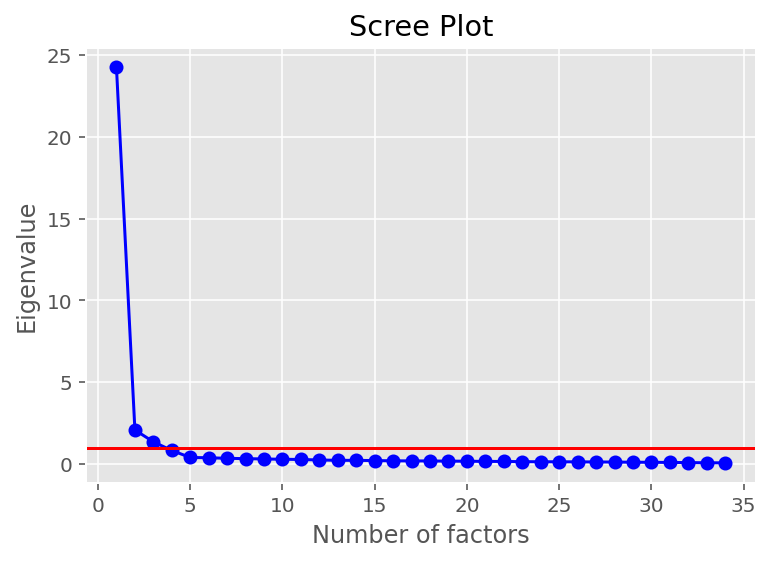

In [13]:
# Check Eigenvalues
fa = FactorAnalyzer()
fa.fit(df)
ev, _ = fa.get_eigenvalues()
scree_plot(ev)

In [14]:
NUM = 4
rotation = 'promax' #oblimin - seperates perfectly by geographical region, quartimin, promax, varimax

In [15]:
# perform factor analysis, method = 'minres' (default), 'ml', 'principal'. minres finds the minimum residuals solution.
fa = perform_fa(df, NUM, rotation, method = 'ml')
# Principal Axis Factor is recommended when the data violate the assumption of multivariate normality (Costello & Osborne, 2005).

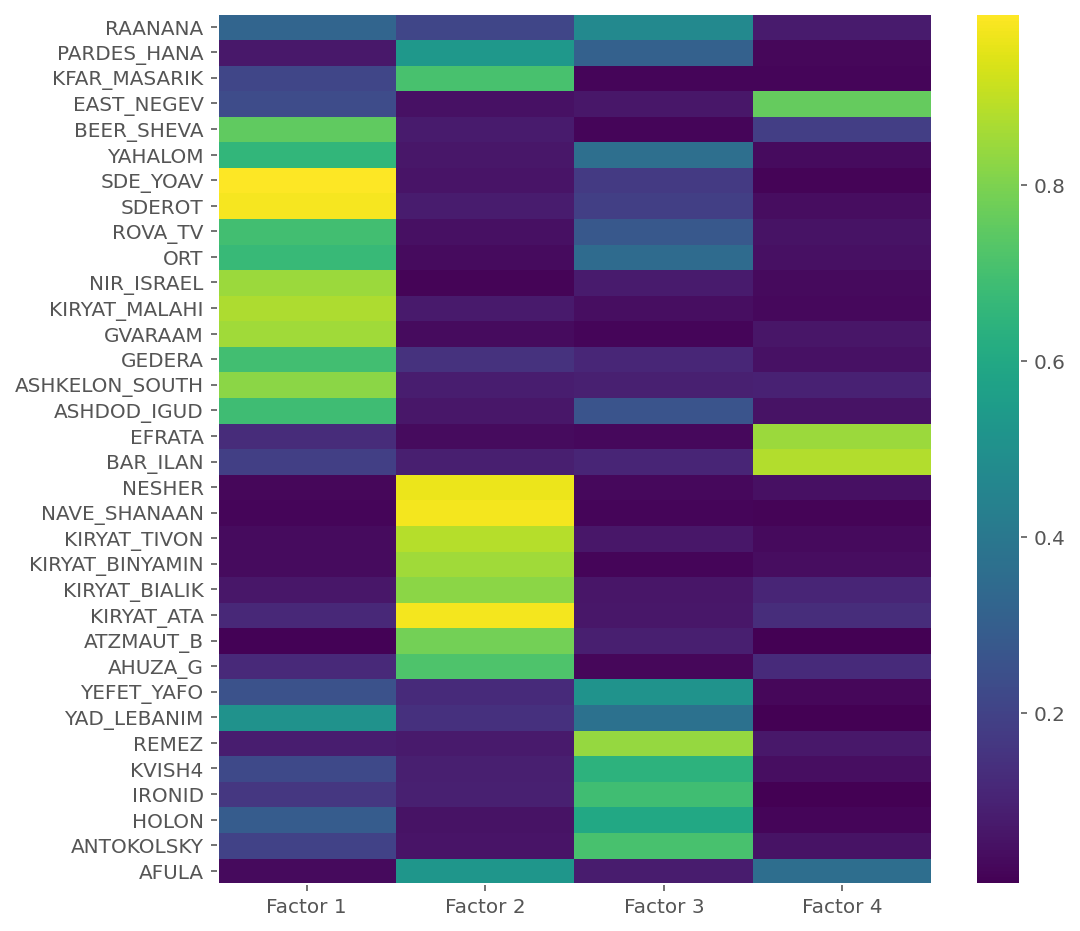

In [16]:
Loadings = fa.loadings_
col_names = df.columns
loadings_plot(Loadings, col_names)

In [17]:
# which stations are Trans/traffic? IRONID,KVISH4,REMEZ,YEFET_YAFO,ATZMAUT,BAR_ILAN,RAANANA. 

In [18]:
# plot on a map to see stations more associated with certain factors
stations = pd.read_csv("~/Documents/saved_data_from_notebooks/stations_info.csv") 

In [19]:
# ascribe a factor to each station based on max loading value (and show it on map)

In [20]:
stations['factor'] = np.argmax(abs(Loadings),axis=1)+1
stations['max_load'] = np.max(abs(Loadings),axis=1)

In [21]:
stations

,name,type,X,Y,Lon,Lat,HASL,HAGL,factor,max_load
0,AFULA,Gener,227646,723263,35.290982,32.603289,53.0,16.000000,2,0.524585
1,ANTOKOLSKY,Gener,179676,665772,34.781938,32.083413,23.8,12.000000,3,0.704872
2,HOLON,Gener,178260,658402,34.767689,32.017671,17.0,15.800000,3,0.600455
3,IRONID,Trans,180414,666788,34.790148,32.093370,10.0,3.800000,3,0.691581
4,KVISH4,Trans,185207,664177,34.841016,32.069980,47.0,3.800000,3,0.641260
5,REMEZ,Trans,183802,666558,34.826045,32.091480,19.0,3.800000,3,0.839605
6,YAD_LEBANIM,Gener,183259,664871,34.820641,32.076766,56.0,17.799999,1,0.505778
7,YEFET_YAFO,Trans,176798,661903,34.752061,32.049187,19.0,3.800000,3,0.513903
8,AHUZA_G,Gener,199059,743556,34.985998,32.786114,274.0,15.300000,2,0.717190
9,ATZMAUT_B,Trans,200549,746930,35.001834,32.816567,13.0,3.800000,2,0.782570


/home/idit/.pyenv/versions/3.6.4/envs/global3.6.4/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



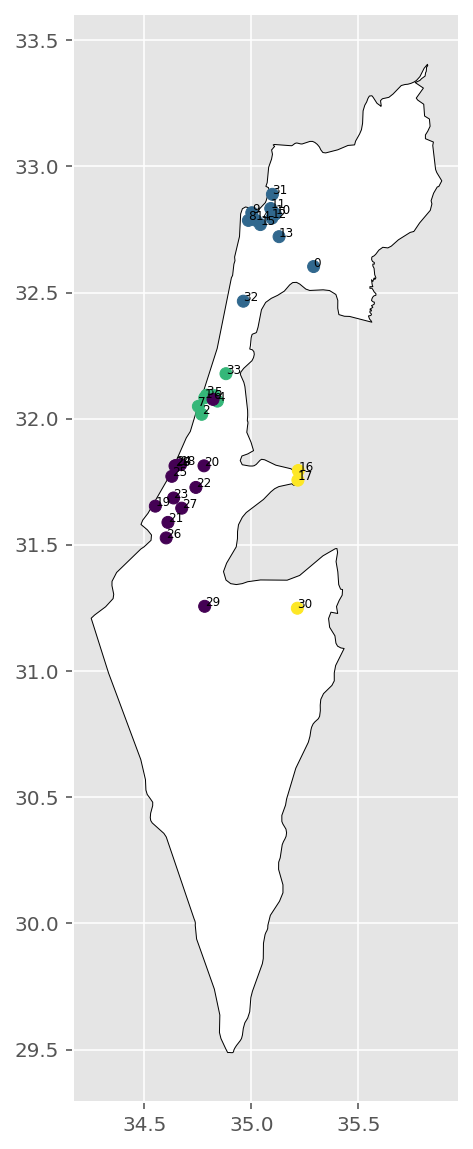

In [22]:
gdf = gp.read_file("/home/idit/Documents/saved_data_from_notebooks/IsraelBorder.shp")
plot_map(gdf,stations)
# as far as I understand the numbers display the value of cummunality - how much that ascribed factor explain out of 
# the variance of the station (0-1). 

we can see that the common variance is mainly related to geographical areas. It is a proof that PM2.5 is highly related to meteorological conditions. 

Common variance is the amount of variance that is shared among a set of features (stations). stations that are highly correlated will share a lot of variance.

### understanding variance explained 

Communality (also called $h^2$) is a definition of common variance that ranges between 0 and 1. Values closer to 1 suggest that extracted factors explain more of the variance of an individual station.
Unique variance is any portion of variance that’s not common and it equals Specific variance (specific per station) + Error variance (anything unexplained by common or specific variance)

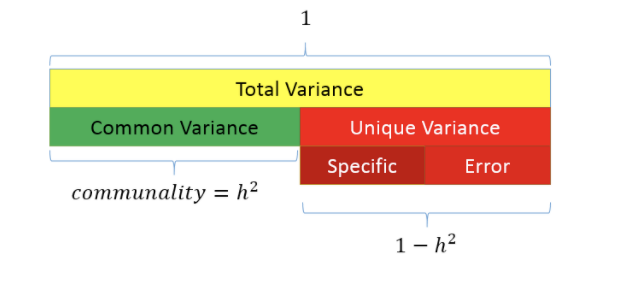

In [23]:
# 1. Sum of squared loadings (variance)
# 2. Proportional variance
# 3. Cumulative variance
fa.get_factor_variance()

(array([8.54188271, 7.40319025, 3.71073087, 2.32562625]),
 array([0.25123184, 0.21774089, 0.10913914, 0.06840077]),
 array([0.25123184, 0.46897273, 0.57811188, 0.64651265]))

In [24]:
# common variance (=Sum of squared loadings)
np.sum(Loadings**2,axis=0)

array([8.54188271, 7.40319025, 3.71073087, 2.32562625])

In [25]:
# mean loadings of each factor (=proportional variance)
np.mean(Loadings**2,axis=0)

array([0.25123184, 0.21774089, 0.10913914, 0.06840077])

In [26]:
# mean explained total variance (=Cumulative variance)
np.cumsum(np.mean(Loadings**2,axis=0))

array([0.25123184, 0.46897273, 0.57811188, 0.64651265])

In [27]:
# this should equal the communalities. We might want to remove stations that
# not enough variance is accounted for by the chosen factors (=low communalities)
# "A particular set of factors is said to explain a lot of the variance of a variable if it has a high communality"
# "Often times variables with low communalities (less than .20 so that 80% is unique variance) are eliminated from the analysis since the aim of factor analysis is to try and explain the variance through the common factors"
fa.get_communalities()
np.sum(Loadings**2,axis=1)

array([0.4120163 , 0.54288573, 0.44772742, 0.51412859, 0.47071065,
       0.72255208, 0.4163052 , 0.34559554, 0.54487092, 0.6207461 ,
       0.9929462 , 0.6969371 , 0.73007548, 0.79064335, 0.95514661,
       0.93491473, 0.82938887, 0.73322053, 0.54902786, 0.70480703,
       0.51783541, 0.73056674, 0.76703208, 0.7247665 , 0.57312604,
       0.56111259, 1.00340918, 1.02361141, 0.56740214, 0.6082457 ,
       0.63998344, 0.54796981, 0.38555142, 0.37617134])

array([0.4120163 , 0.54288573, 0.44772742, 0.51412859, 0.47071065,
       0.72255208, 0.4163052 , 0.34559554, 0.54487092, 0.6207461 ,
       0.9929462 , 0.6969371 , 0.73007548, 0.79064335, 0.95514661,
       0.93491473, 0.82938887, 0.73322053, 0.54902786, 0.70480703,
       0.51783541, 0.73056674, 0.76703208, 0.7247665 , 0.57312604,
       0.56111259, 1.00340918, 1.02361141, 0.56740214, 0.6082457 ,
       0.63998344, 0.54796981, 0.38555142, 0.37617134])

In [28]:
# unique variance
1 - np.sum(Loadings**2,axis=1) 
fa.get_uniquenesses()

array([ 0.5879837 ,  0.45711427,  0.55227258,  0.48587141,  0.52928935,
        0.27744792,  0.5836948 ,  0.65440446,  0.45512908,  0.3792539 ,
        0.0070538 ,  0.3030629 ,  0.26992452,  0.20935665,  0.04485339,
        0.06508527,  0.17061113,  0.26677947,  0.45097214,  0.29519297,
        0.48216459,  0.26943326,  0.23296792,  0.2752335 ,  0.42687396,
        0.43888741, -0.00340918, -0.02361141,  0.43259786,  0.3917543 ,
        0.36001656,  0.45203019,  0.61444858,  0.62382866])

array([ 0.5879837 ,  0.45711427,  0.55227258,  0.48587141,  0.52928935,
        0.27744792,  0.5836948 ,  0.65440446,  0.45512908,  0.3792539 ,
        0.0070538 ,  0.3030629 ,  0.26992452,  0.20935665,  0.04485339,
        0.06508527,  0.17061113,  0.26677947,  0.45097214,  0.29519297,
        0.48216459,  0.26943326,  0.23296792,  0.2752335 ,  0.42687396,
        0.43888741, -0.00340918, -0.02361141,  0.43259786,  0.3917543 ,
        0.36001656,  0.45203019,  0.61444858,  0.62382866])

In [29]:
# identify cross-loadings (A crossloading is when an item loads at .32 or higher on two or more factors (Costello & Osborne, 2005))
stations.loc[np.sum(Loadings>0.32,axis=1)>1,'name']

0           AFULA
6     YAD_LEBANIM
24            ORT
28        YAHALOM
33        RAANANA
Name: name, dtype: object

In [30]:
# according to matlab: 
# cov(x)=ΛΛ.T+Ψ 
# psi = np.cov(df.values) - np.dot(Loadings,Loadings.T) #it destroys the kernel

In [31]:
normalized_df=(df-df.mean())/df.std()

In [32]:
arr = normalized_df.values
cov_mat = np.dot(arr.T, arr) # how to rotate?

In [33]:
cov_mat - np.dot(Loadings,Loadings.T)

array([[105164.58798369,  75934.45160921,  72263.0483002 , ...,
         80892.1499239 ,  77891.5437672 ,  72772.61376962],
       [ 75934.45160921, 105164.45711427,  90312.23118457, ...,
         76845.73424609,  81208.33632013,  85269.31234805],
       [ 72263.0483002 ,  90312.23118457, 105164.55227258, ...,
         73684.72154442,  76909.81023391,  83802.77616089],
       ...,
       [ 80892.1499239 ,  76845.73424609,  73684.72154442, ...,
        105164.45203022,  76387.93678689,  75783.22682003],
       [ 77891.5437672 ,  81208.33632013,  76909.81023391, ...,
         76387.93678689, 105164.61444859,  80561.79216547],
       [ 72772.61376962,  85269.31234805,  83802.77616089, ...,
         75783.22682003,  80561.79216547, 105164.62382866]])

### bar-plot of loadings

In [34]:
df_load = pd.DataFrame(Loadings,columns=['F1','F2','F3','F4'])

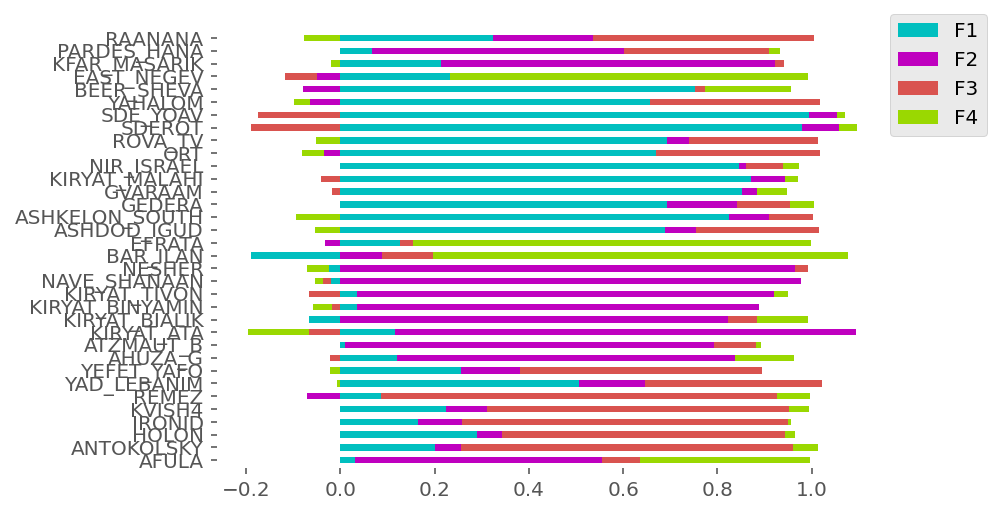

In [35]:
ax = df_load.plot(kind='barh', stacked=True, color=['c','m','#d9534f','#9ad801'])
ax.legend(loc=[1.005,0.76])
ax.set_yticks(np.arange(0,34))
ax.set_yticklabels(df.columns)
ax.set_facecolor('white')
plt.show();

In [36]:
"if the factors are correlated (oblique), the factor loadings are regression coefficients and not correlations and as such they can be larger than one in magnitude"

'if the factors are correlated (oblique), the factor loadings are regression coefficients and not correlations and as such they can be larger than one in magnitude'

### reconstract a signal due to one of the factors. 

In [37]:
Rotations = fa.rotation_matrix_

In [38]:
Rotations

array([[ 0.4634088 ,  0.32082831, -0.07459941, -0.24375288],
       [-1.13356381,  1.51062012, -0.06657983,  0.36707816],
       [-0.00385579,  0.41200029,  1.28863651, -0.63420394],
       [ 1.4273663 ,  0.59315145,  0.53810707,  1.65611874]])

In [39]:
factors = np.dot(df,Loadings)

In [40]:
factors

array([[483.60998309, 185.99969154, 231.57714422,  67.08341021],
       [510.670666  , 201.94663261, 232.74062622,  75.2714438 ],
       [550.40704083, 223.23802152, 268.07287711,  72.17192041],
       ...,
       [212.8954056 , 260.53490778, 170.39877085,  53.68932606],
       [266.56831128, 262.0563364 , 170.64423744,  49.2091306 ],
       [303.79783628, 266.26746515, 194.76974288,  42.33512213]])

In [41]:
scores = fa.transform(df) # numerical value, no units

# factor loadings  = the weight of each factor on the observed variables
# factor scores = the weights of each observed variable in producing a score representing the factor

In [42]:
scores

array([[ 0.99251599, -0.03450792,  0.0019487 ,  0.62830549],
       [ 1.13822861,  0.00595312,  0.12004865,  0.58034116],
       [ 1.30630843,  0.11326699, -0.01785261,  0.90319164],
       ...,
       [-0.26022963,  0.59791901, -0.19620338,  0.39496498],
       [-0.03270807,  0.54111271, -0.23404204,  0.33299572],
       [ 0.08700786,  0.57868944, -0.38266917,  0.5127267 ]])

### Look at daily/weekly/monthly patterns of the factors 

In [93]:
times.rename({'0': 'time'}, axis = 'columns',inplace=True)
# df_scores.set_index(times['time'],drop=True,inplace=True)
# df_scores.index = pd.to_datetime(df_scores.index,format='%Y-%m-%d %H:%M')
# df_scores.head()

In [94]:
df_scores = pd.DataFrame(scores, columns=['F1','F2','F3','F4'])

In [95]:
df_scores['datetime'] = pd.to_datetime(times['time'], format='%Y-%m-%d %H:%M')
df_scores['week day'] = pd.to_datetime(times['time']).dt.dayofweek+1
df_scores['month'] = pd.to_datetime(times['time']).dt.month
df_scores['hour'] = pd.to_datetime(times['time']).dt.hour
df_scores['minute'] = pd.to_datetime(times['time']).dt.minute
df_scores['Day in year'] = pd.to_datetime(times['time']).dt.dayofyear
# df_scores.drop(['week day','month','hour'],axis=1,inplace=True)

In [96]:
df_scores.loc[df_scores['week day']==7,'week day']=0

In [139]:
df_scores.groupby(['week day','hour','minute']).mean()

F1        F2        F3        F4     month  \
week day hour minute                                                     
0        0    0      -0.059072 -0.086281 -0.055188 -0.003529  6.536741   
              30     -0.036074 -0.092185 -0.061802 -0.006431  6.536741   
         1    0      -0.021879 -0.091453 -0.089229 -0.019859  6.536741   
              30     -0.007457 -0.104401 -0.123611 -0.031872  6.536741   
         2    0      -0.004645 -0.091516 -0.140252 -0.023241  6.536741   
...                        ...       ...       ...       ...       ...   
6        21   30     -0.131183 -0.087390 -0.074679 -0.053171  6.539936   
         22   0      -0.122461 -0.089342 -0.069890 -0.014815  6.539936   
              30     -0.110356 -0.089446 -0.061967  0.004246  6.539936   
         23   0      -0.098642 -0.080121 -0.050998 -0.000452  6.539936   
              30     -0.072763 -0.091746 -0.047709  0.010313  6.539936   

                      Day in year  
week day hour minute               
0        0    0        183.415335  
              30       183.415335  
         1    0        183.415335  
              30       183.415335  
         2    0        183.415335  
...                           ...  
6        21   30       183.584665  
         22   0        183.584665  
              30       183.584665  
         23   0        183.584665  
              30       183.584665  

[336 rows x 6 columns]

In [117]:
mpl.style.use('seaborn-white')

In [164]:
df_scores.groupby(['hour','minute']).mean()

F1        F2        F3        F4  week day     month  \
hour minute                                                               
0    0       0.027443 -0.029552 -0.006391  0.041343  3.000000  6.523962   
     30      0.043451 -0.034983 -0.023838  0.048756  3.000000  6.523962   
1    0       0.054787 -0.042853 -0.037078  0.033297  3.000000  6.523962   
     30      0.064970 -0.056647 -0.060896  0.021069  3.000000  6.523962   
2    0       0.065440 -0.046799 -0.075581  0.028093  3.000000  6.523962   
     30      0.057768 -0.054154 -0.080918  0.049632  3.000000  6.523962   
3    0       0.050522 -0.043582 -0.073731  0.058341  3.000000  6.523962   
     30      0.037902 -0.046538 -0.071685  0.063189  3.000000  6.523962   
4    0       0.024092 -0.030449 -0.073543  0.066506  3.000000  6.523962   
     30      0.011062 -0.015419 -0.079016  0.071364  3.000000  6.523962   
5    0      -0.002519  0.001928 -0.084256  0.082489  3.000000  6.523962   
     30     -0.023531  0.026171 -0.088339  0.082843  3.000000  6.523962   
6    0      -0.053334  0.032178 -0.103494  0.074909  3.000000  6.523962   
     30     -0.085144  0.036991 -0.104888  0.062347  3.000000  6.523962   
7    0      -0.112853  0.030151 -0.112403  0.063643  3.000000  6.523962   
     30     -0.136902  0.020790 -0.119086  0.057891  3.000000  6.523962   
8    0      -0.127414  0.014790 -0.125377  0.050461  3.000000  6.523962   
     30     -0.097392  0.020584 -0.111238  0.042526  3.000000  6.523962   
9    0      -0.064461  0.028879 -0.096291  0.041087  3.000000  6.523962   
     30     -0.022948  0.040196 -0.076431  0.058568  3.000000  6.523962   
10   0       0.012534  0.041272 -0.052596  0.053994  3.000000  6.523962   
     30      0.045244  0.030581 -0.029737  0.039683  3.000000  6.523962   
11   0       0.074388  0.017027 -0.012360  0.000346  3.000000  6.523962   
     30      0.087870  0.019557  0.024815 -0.036180  3.000000  6.523962   
12   0       0.075530  0.034801  0.042034 -0.049935  3.000000  6.523962   
     30      0.055155  0.038694  0.051178 -0.041553  3.000000  6.523962   
13   0       0.044387  0.052162  0.060705 -0.036604  3.000000  6.523962   
     30      0.025014  0.050972  0.080494 -0.026138  3.000000  6.523962   
14   0       0.004633  0.038396  0.097010 -0.028479  3.000000  6.523962   
     30     -0.001875  0.023072  0.112801 -0.050392  3.000000  6.523962   
15   0      -0.004263  0.013567  0.112477 -0.073050  3.000000  6.523962   
     30      0.003968  0.009866  0.114851 -0.070290  3.000000  6.523962   
16   0       0.015891  0.006200  0.122061 -0.068346  3.000000  6.523962   
     30      0.030381 -0.005404  0.135092 -0.072599  3.000000  6.523962   
17   0       0.036092 -0.012804  0.148656 -0.085121  3.000000  6.523962   
     30      0.026020 -0.013137  0.136019 -0.100022  3.000000  6.523962   
18   0       0.011219 -0.005475  0.107095 -0.104955  3.000000  6.523962   
     30      0.003036 -0.005710  0.081615 -0.109107  3.000000  6.523962   
19   0      -0.016921 -0.011722  0.053972 -0.120656  3.000000  6.523962   
     30     -0.035465 -0.017359  0.035584 -0.111932  3.000000  6.523962   
20   0      -0.047580 -0.019500  0.030524 -0.082951  3.000000  6.523962   
     30     -0.048374 -0.018762  0.033163 -0.048716  3.000000  6.523962   
21   0      -0.043090 -0.017999  0.030359 -0.016537  3.000000  6.523962   
     30     -0.029779 -0.015937  0.028531  0.006670  3.000000  6.523962   
22   0      -0.021005 -0.015871  0.018700  0.021508  3.000000  6.523962   
     30     -0.015203 -0.019350  0.019567  0.028825  3.000000  6.523962   
23   0      -0.011010 -0.017618  0.013103  0.037633  3.000913  6.521461   
     30      0.012266 -0.031227  0.008777  0.046588  3.000913  6.521461   

             Day in year  
hour minute               
0    0        183.083524  
     30       183.083524  
1    0        183.083524  
     30       183.083524  
2    0        183.083524  
     30       183.083524  
3    0        183.083524  
     30       183.083524 

In [172]:
np.linspace(1,48-1,24)
[str(i) for i in range(24)]

array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25.,
       27., 29., 31., 33., 35., 37., 39., 41., 43., 45., 47.])

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23']

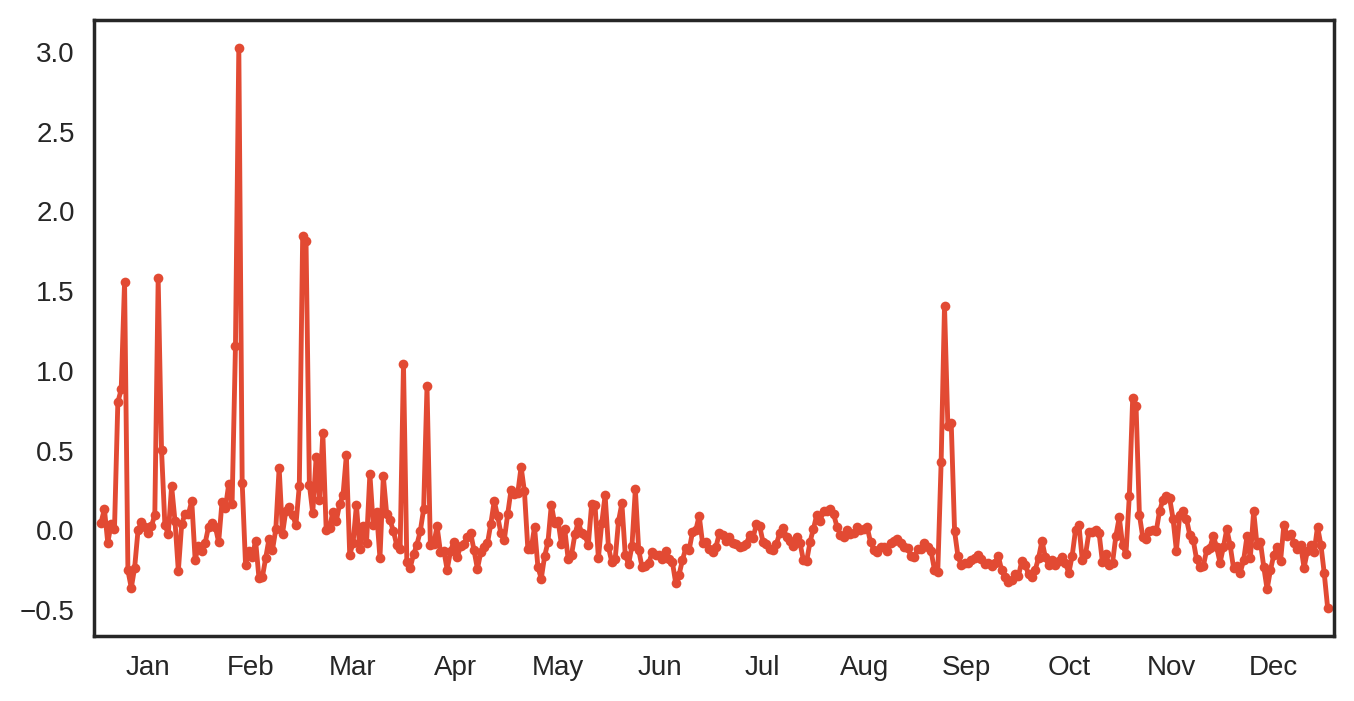

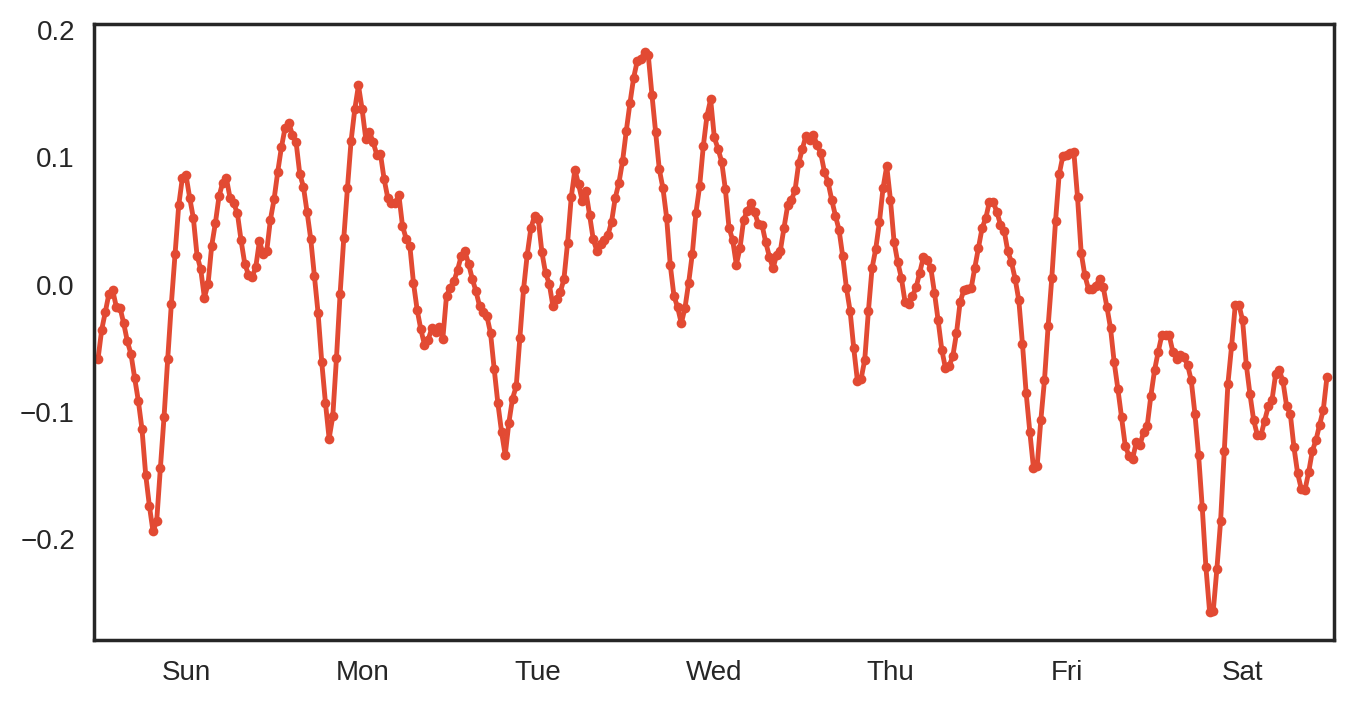

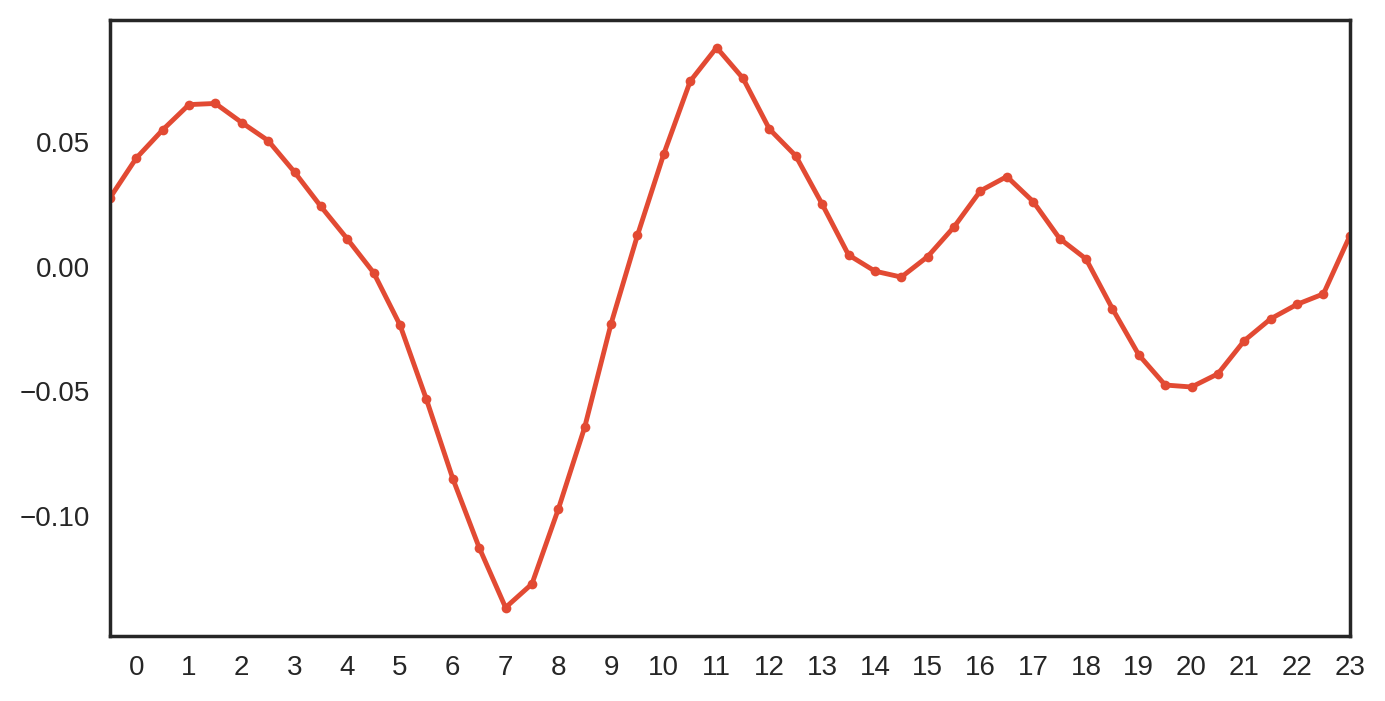

In [179]:


#1
fig, ax = plt.subplots(figsize=(8,4))
df_scores.groupby(['Day in year']).mean()['F1'].plot(style='.-')
plt.xlim([-1,368])
plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
plt.xlabel('')
plt.show();

#2
fig, ax = plt.subplots(figsize=(8,4))
df_scores.groupby(['week day','hour','minute']).mean()['F1'].plot(style='.-')
plt.xlim([-1,48*7+1])
plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))
plt.xlabel('')
plt.show();

#3
fig, ax = plt.subplots(figsize=(8,4))
df_scores.groupby(['hour','minute']).mean()['F1'].plot(style='.-')
plt.xlim([0,47])
plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
plt.xlabel('')
plt.show();

In [121]:
# fig, ax = plt.subplots(figsize=(15,5))

# bp = df_scores.boxplot(column=['F1'], by=['hour','minute'], ax=ax, fontsize=16,
#                     showfliers=False, showmeans=True,return_type='dict')

# [[item.set_linewidth(3) for item in bp[key]['boxes']] for key in bp.keys()]
# [[item.set_linewidth(3) for item in bp[key]['fliers']] for key in bp.keys()]
# [[item.set_linewidth(3) for item in bp[key]['medians']] for key in bp.keys()]
# [[item.set_linewidth(3) for item in bp[key]['means']] for key in bp.keys()]
# [[item.set_linewidth(3) for item in bp[key]['whiskers']] for key in bp.keys()]
# [[item.set_linewidth(3) for item in bp[key]['caps']] for key in bp.keys()]

# # title_boxplot = 'awesome title'
# # plt.title( title_boxplot )
# plt.suptitle('') # that's what you're after
# # plt.ylim([0,40])
# ax.set_xlabel('')
# # ax.set_ylabel('$\mu g/m^3$',fontsize=16)
# plt.show();

### find correlation with NOx

# Confirmatory FA 

In [ ]:
# https://buildmedia.readthedocs.org/media/pdf/factor-analyzer/latest/factor-analyzer.pdf

In [29]:
'''Confirmatory factor analysis (CFA), a closely associated technique, 
is used to test an a priori hypothesis about latent relationships among sets of 
observed variables. In CFA, the researcher specifies the expected pattern of factor 
loadings (and possibly other constraints), and fits a model according to this specification.'''

'Confirmatory factor analysis (CFA), a closely associated technique, is used to test an a priori hypothesis about latent relationships among sets of observed variables. In CFA, the researcher specifies the expected pattern of factor loadings (and possibly other constraints), and fits a model according to this specification.'

In [47]:
model_dict = {"F1": ["IRONID", "KVISH4", "REMEZ", "YEFET_YAFO","ATZMAUT_B","BAR_ILAN","RAANANA"],
              "F2": ['AFULA', 'ANTOKOLSKY', 'HOLON', 
                   'YAD_LEBANIM', 'AHUZA_G','KIRYAT_ATA',
                   'KIRYAT_BIALIK', 'KIRYAT_BINYAMIN', 'KIRYAT_TIVON', 'NAVE_SHANAAN',
                   'NESHER', 'EFRATA', 'ASHDOD_IGUD', 'ASHKELON_SOUTH',
                   'GEDERA', 'GVARAAM', 'KIRYAT_MALAHI', 'NIR_ISRAEL', 'ORT', 'ROVA_TV',
                   'SDEROT', 'SDE_YOAV', 'YAHALOM', 'BEER_SHEVA', 'EAST_NEGEV',
                   'KFAR_MASARIK', 'PARDES_HANA']}
model_spec = ModelSpecificationParser.parse_model_specification_from_dict(df,model_dict)

In [52]:
cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=True, max_iter=5000)

In [53]:
cfa.fit(df.values)

/home/idit/.pyenv/versions/3.6.4/envs/global3.6.4/lib/python3.6/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning:

The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'



ConfirmatoryFactorAnalyzer(max_iter=5000, n_obs=105166,
                           specification=<factor_analyzer.confirmatory_factor_analyzer.ModelSpecification object at 0x7fd24530f588>)

In [54]:
cfa.loadings_

array([[ 9.40096879,  0.        ],
       [11.56854439,  0.        ],
       [10.2154797 ,  0.        ],
       [10.45767374,  0.        ],
       [10.94556523,  0.        ],
       [11.93193772,  0.        ],
       [11.36859438,  0.        ],
       [ 0.        ,  6.62980632],
       [ 0.        , 10.10346062],
       [ 0.        ,  6.61773597],
       [ 0.        ,  9.27757544],
       [ 0.        ,  8.21083942],
       [ 0.        ,  6.00050443],
       [ 0.        ,  6.56220045],
       [ 0.        ,  6.41121661],
       [ 0.        ,  6.09766888],
       [ 0.        ,  7.88181932],
       [ 0.        ,  9.6577618 ],
       [ 0.        , 10.10612691],
       [ 0.        ,  9.16746846],
       [ 0.        , 12.5059155 ],
       [ 0.        , 13.03685983],
       [ 0.        ,  9.84949132],
       [ 0.        , 12.68236565],
       [ 0.        ,  8.71177704],
       [ 0.        , 10.06249891],
       [ 0.        , 11.89953472],
       [ 0.        , 11.81289239],
       [ 0.        ,

In [55]:
cfa.factor_varcovs_

array([[1.        , 0.72576772],
       [0.72576772, 1.        ]])

# ICA

In [484]:
ica = FastICA(n_components=NUM)
S_ = ica.fit_transform(df)  # Reconstruct signals = factors
fa.loadings_ = ica.mixing_  # Get estimated mixing matrix = loadings


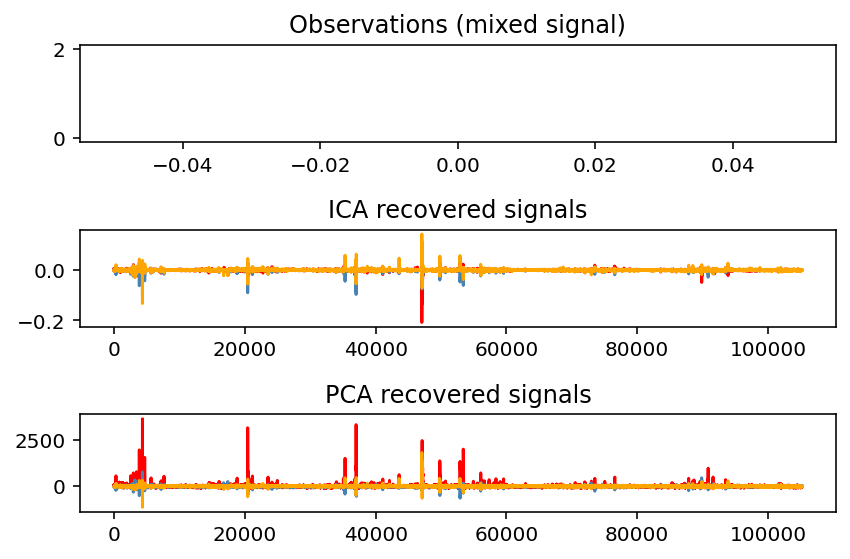

In [477]:
# #############################################################################
X = df.copy()
# S /= S.std(axis=0)  # Standardize data
# # Mix data
# A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
# X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals = factors
A_ = ica.mixing_  # Get estimated mixing matrix = loadings

# # We can `prove` that the ICA model applies by reverting the unmixing.
# assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

# #############################################################################
# Plot results

plt.figure()

models = [X, S_, H]
names = ['Observations (mixed signal)',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(3, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show();

In [483]:
A_

array([[-3986.49868082, -5229.02940946,   -24.63857135],
       [ -986.76038526, -6494.22005296,    97.36456816],
       [ -730.91228849, -6140.95687262,   135.21046555],
       [ -880.59684253, -6249.20661389,  -277.16016221],
       [ -994.67215702, -6583.48860923,    29.67112943],
       [ -618.58967733, -7213.45038378,   192.61819595],
       [-1035.0074852 , -7385.43947014,   376.58399746],
       [ -593.49255582, -4648.32868612,  -164.81165463],
       [-3961.42107674, -5996.32287051, -1244.68334866],
       [-2529.90511991, -4288.52294711, -1498.05501597],
       [-3236.17364162, -5986.3797002 , -2575.72989093],
       [-3792.89080573, -5186.03489218, -1758.84750258],
       [-2560.57528297, -4133.6409216 , -1791.58610279],
       [-2833.47915225, -4155.43581347, -1498.95403782],
       [-2536.23043986, -3929.32208708, -1494.33860939],
       [-2361.88427092, -3902.51111963, -1546.45358255],
       [-5701.55438543, -3834.96367359,  2964.53046169],
       [-4818.98138972, -4805.9

In [482]:
(np.dot(S_, A_.T) + ica.mean_).shape
X.shape

(105166, 34)

(105166, 34)

In [ ]:
# dynamic FA

# file:///Users/iditbela/Downloads/Dynamic_factor_analysis_to_estimate_common_trends_.pdf
# https://projecteuclid.org/download/pdf_1/euclid.ba/1340370408
# https://pure.au.dk/portal/files/104842477/PhD_dissertation_Jakob_G_Mikkelsen.pdf#page=18

# Trash

In [553]:
# geoplot.polyplot(gdf, figsize=(8, 4)) # this gives empty plot - is X and Y oposite? is it not centered?

# # one option - specify the projection - didn't work (something with centering)
# geoplot.polyplot(gdf, projection=gcrs.TransverseMercator(), figsize=(8, 4))